In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

import torchvision
import torchvision.transforms as transforms


import time

import numpy as np
import matplotlib.pyplot as plt

## Utils

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [ ]:
def test(model, device, test_loader):
  correct = 0
  total = 0
  model.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(inputs)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

## Standard SGD

In [ ]:
# Function for training with standard mini-batch SGD
def train_standard_sgd(
    model, device, train_loader,
    optimizer, epoch, verbose=True):

  model.train()
  running_loss = 0.0
  print('\n=> Training Epoch #%d' % (epoch))

  for batch_idx, (data, target) in enumerate(train_loader):
      # save data and target to device
      data, target = data.to(device), target.to(device)

      # zero parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      output = model(data)
      loss = nn.functional.cross_entropy(output, target)
      loss.backward()
      optimizer.step()

      # print statistics
      if verbose:
        running_loss += loss.item()
        if batch_idx % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {batch_idx * train_loader.batch_size}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

## Sorting Forgetting Scores

In [ ]:
# Function for training with mini-batch SGD considering forgetting score
def train_with_forgetting_score_deterministic(
      model, device, train_loader, optimizer,
      epoch, B_b, prev_acc, forgetting_T, verbose=True):

    model.train()
    total_forgotten = 0

    running_loss = 0.0
    print('\n=> Training Epoch #%d' % (epoch))
    for batch_idx, (data, target) in enumerate(train_loader):
        m = int(len(data) * B_b)
        data, target = data.to(device), target.to(device)

        # Save predictions
        with torch.no_grad():
            new_output = model(data)
            new_pred = new_output.argmax(dim=1, keepdim=True) #TODO: compute acci should be done in inner for loop

        # Calculate forgetting score for each image in batch
        for i in range(len(data)):
          new_correct = int(new_pred[i].eq(target[i].view_as(new_pred[i])).item())

          index = batch_idx * train_loader.batch_size + i #Get image index
          if prev_acc[index] > new_correct: #previous prediction is correctly classified (true 1) > new prediction misclassified (false 0)
            forgetting_T[index] += 1
            total_forgotten += 1

          prev_acc[index] = new_correct

        # Sort examples by forgetting score in descending order within the batch
        batch_forgetting_scores = [(i, forgetting_T[i]) for i in range(len(data))]
        batch_forgetting_scores = sorted(batch_forgetting_scores, key=lambda x: x[1], reverse=True)

        # Choose the top m examples with the highest forgetting scores within the batch
        selected_examples = [i for i, _ in batch_forgetting_scores[:m]]

        # Training on selected examples within the batch
        model.train()
        optimizer.zero_grad()

        # Run only the selected examples through the model
        selected_output = model(data[selected_examples])
        selected_target = target[selected_examples]

        loss = nn.functional.cross_entropy(selected_output, selected_target)
        loss.backward()
        optimizer.step()

        # print statistics
        if verbose:
          running_loss += loss.item()
          if batch_idx % 100 == 99:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {batch_idx * m}] loss: {running_loss / 100:.3f}')
              running_loss = 0.0

    return total_forgotten

## Probabilistic Sampling on Forgetting Score

In [ ]:
# Function for training with mini-batch SGD considering forgetting score
def train_with_forgetting_score_probabilistic(
      model, device, train_loader, optimizer, epoch, B_b,
      prev_acc, forgetting_T, random=False, verbose=True):

    model.train()
    average_forgetting_score = 0

    running_loss = 0.0
    print('\n=> Training Epoch #%d' % (epoch))
    for batch_idx, (data, target) in enumerate(train_loader):
        m = int(len(data) * B_b)

        # sample m points from b based on forgetting score
        forgetting_scores = forgetting_T[batch_idx * train_loader.batch_size: batch_idx * train_loader.batch_size + len(data) - 1]
        if random:
          probabilities = torch.ones(len(data) - 1) / len(data)
        else:
          probabilities = F.softmax(forgetting_scores.float(), dim=0)
        sampled_indices = torch.multinomial(probabilities, m, replacement=False)

        # get subset of mini-batch based on sampling
        selected_data = torch.index_select(data, 0, sampled_indices).to(device)
        selected_target = torch.index_select(target, 0, sampled_indices).to(device)

        # for statistics
        selected_forgetting_scores = torch.index_select(forgetting_scores, 0, sampled_indices)
        average_forgetting_score = sum(selected_forgetting_scores) / len(selected_forgetting_scores)

        # Save predictions
        with torch.no_grad():
            new_output = model(selected_data)
            new_pred = new_output.argmax(dim=1, keepdim=True)

        # update forgetting scores for chosen subset
        for idx, i in enumerate(sampled_indices):
          new_correct = int(new_pred[idx].eq(selected_target[idx].view_as(new_pred[idx])).item())

          index = batch_idx * train_loader.batch_size + i #Get image index
          if prev_acc[index] > new_correct: #previous prediction is correctly classified (true 1) > new prediction misclassified (false 0)
            forgetting_T[index] += 1

          prev_acc[index] = new_correct

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize on chosen subset
        output = model(selected_data)
        loss = nn.functional.cross_entropy(output, selected_target)
        loss.backward()
        optimizer.step()

        # print statistics
        if verbose:
          running_loss += loss.item()
          if batch_idx % 100 == 99:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {batch_idx * m}] loss: {running_loss / 100:.3f}')
              running_loss = 0.0
    return average_forgetting_score

## Test-Train Pipeline

In [ ]:
# testing parameters
epochs = 100
batch_size = 64
B_b = 0.1
augmented_batch_size = int(batch_size / B_b)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 44489897.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Train-test functions

In [ ]:
# Standard SGD
def train_test_standard():
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
  test_accuracies = []

  elapsed_time = 0
  for epoch in range(epochs):
      start_time = time.time()

      train_standard_sgd(net, device, train_loader, optimizer, epoch, verbose=False)
      acc = test(net, device, test_loader)
      test_accuracies.append(acc)
      print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')

      epoch_time = time.time() - start_time
      elapsed_time += epoch_time
      print('| Elapsed time : %d:%02d:%02d' % (get_hms(elapsed_time)))
  return test_accuracies


In [ ]:
# Determinisitc SGD
def train_test_deterministic():
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=augmented_batch_size,
                                          shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=augmented_batch_size,
                                         shuffle=False, num_workers=2)
  test_accuracies = []

  prev_acc = torch.zeros_like(torch.tensor(trainset.targets))
  forgetting_T = torch.zeros_like(torch.tensor(trainset.targets))

  elapsed_time = 0
  total_forgotten = 0
  for epoch in range(epochs):
      start_time = time.time()

      total_forgotten += train_with_forgetting_score_deterministic(
          net, device, train_loader, optimizer,
          epoch, B_b, prev_acc, forgetting_T, verbose=False)

      acc = test(net, device, test_loader)
      test_accuracies.append(acc)
      print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
      print(f'Total forgotten: {total_forgotten}')

      epoch_time = time.time() - start_time
      elapsed_time += epoch_time
      print('| Elapsed time : %d:%02d:%02d' % (get_hms(elapsed_time)))
  return test_accuracies

In [ ]:
# Probabilistic SGD
def train_test_probabilistic():
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=augmented_batch_size,
                                          shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=augmented_batch_size,
                                         shuffle=False, num_workers=2)
  test_accuracies = []
  forgetting_score_averages = []

  prev_acc = torch.zeros_like(torch.tensor(trainset.targets))
  forgetting_T = torch.zeros_like(torch.tensor(trainset.targets))

  elapsed_time = 0
  total_forgotten = 0
  for epoch in range(epochs):
      start_time = time.time()

      f_score_avg = train_with_forgetting_score_probabilistic(
          net, device, train_loader, optimizer,
          epoch, B_b, prev_acc, forgetting_T, random=False, verbose=False)

      acc = test(net, device, test_loader)
      test_accuracies.append(acc)
      forgetting_score_averages.append(f_score_avg)
      print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
      print(f'Total forgotten: {total_forgotten}')

      epoch_time = time.time() - start_time
      elapsed_time += epoch_time
      print('| Elapsed time : %d:%02d:%02d' % (get_hms(elapsed_time)))
  return test_accuracies, forgetting_score_averages

In [ ]:
# Random subset SGD
def train_test_random():
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=augmented_batch_size,
                                          shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=augmented_batch_size,
                                         shuffle=False, num_workers=2)
  test_accuracies = []
  forgetting_score_averages = []

  # specific params
  prev_acc = torch.zeros_like(torch.tensor(trainset.targets))
  forgetting_T = torch.zeros_like(torch.tensor(trainset.targets))

  elapsed_time = 0
  for epoch in range(epochs):
      start_time = time.time()

      f_score_avg = train_with_forgetting_score_probabilistic(
          net, device, train_loader, optimizer,
          epoch, B_b, prev_acc, forgetting_T, random=True, verbose=False)

      acc = test(net, device, test_loader)
      test_accuracies.append(acc)
      forgetting_score_averages.append(f_score_avg)
      print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')

      epoch_time = time.time() - start_time
      elapsed_time += epoch_time
      print('| Elapsed time : %d:%02d:%02d' % (get_hms(elapsed_time)))
  return test_accuracies, forgetting_score_averages

### Running the tests

In [ ]:
test_accuracies = {}

In [ ]:
test_accuracies['standard'] = train_test_standard()


=> Training Epoch #0
Accuracy of the network on the 10000 test images: 10.32%
| Elapsed time : 0:00:08

=> Training Epoch #1
Accuracy of the network on the 10000 test images: 27.75%
| Elapsed time : 0:00:16

=> Training Epoch #2
Accuracy of the network on the 10000 test images: 33.07%
| Elapsed time : 0:00:24

=> Training Epoch #3
Accuracy of the network on the 10000 test images: 38.25%
| Elapsed time : 0:00:33

=> Training Epoch #4
Accuracy of the network on the 10000 test images: 40.92%
| Elapsed time : 0:00:41

=> Training Epoch #5
Accuracy of the network on the 10000 test images: 44.12%
| Elapsed time : 0:00:49

=> Training Epoch #6
Accuracy of the network on the 10000 test images: 46.56%
| Elapsed time : 0:00:58

=> Training Epoch #7
Accuracy of the network on the 10000 test images: 48.33%
| Elapsed time : 0:01:06

=> Training Epoch #8
Accuracy of the network on the 10000 test images: 50.69%
| Elapsed time : 0:01:14

=> Training Epoch #9
Accuracy of the network on the 10000 test 

In [ ]:
test_accuracies['random'], forgetting_random = train_test_random()


=> Training Epoch #0
Accuracy of the network on the 10000 test images: 9.80%
| Elapsed time : 0:00:07

=> Training Epoch #1
Accuracy of the network on the 10000 test images: 9.96%
| Elapsed time : 0:00:15

=> Training Epoch #2
Accuracy of the network on the 10000 test images: 10.16%
| Elapsed time : 0:00:22

=> Training Epoch #3
Accuracy of the network on the 10000 test images: 10.97%
| Elapsed time : 0:00:30

=> Training Epoch #4
Accuracy of the network on the 10000 test images: 11.75%
| Elapsed time : 0:00:38

=> Training Epoch #5
Accuracy of the network on the 10000 test images: 10.99%
| Elapsed time : 0:00:46

=> Training Epoch #6
Accuracy of the network on the 10000 test images: 11.27%
| Elapsed time : 0:00:53

=> Training Epoch #7
Accuracy of the network on the 10000 test images: 10.77%
| Elapsed time : 0:01:01

=> Training Epoch #8
Accuracy of the network on the 10000 test images: 10.16%
| Elapsed time : 0:01:09

=> Training Epoch #9
Accuracy of the network on the 10000 test im

In [ ]:
test_accuracies['probabilistic'], forgetting_probabilistic = train_test_probabilistic()


=> Training Epoch #0
Accuracy of the network on the 10000 test images: 10.03%
Total forgotten: 0
| Elapsed time : 0:00:07

=> Training Epoch #1
Accuracy of the network on the 10000 test images: 10.11%
Total forgotten: 0
| Elapsed time : 0:00:15

=> Training Epoch #2
Accuracy of the network on the 10000 test images: 10.10%
Total forgotten: 0
| Elapsed time : 0:00:22

=> Training Epoch #3
Accuracy of the network on the 10000 test images: 10.28%
Total forgotten: 0
| Elapsed time : 0:00:30

=> Training Epoch #4
Accuracy of the network on the 10000 test images: 13.91%
Total forgotten: 0
| Elapsed time : 0:00:38

=> Training Epoch #5
Accuracy of the network on the 10000 test images: 16.24%
Total forgotten: 0
| Elapsed time : 0:00:46

=> Training Epoch #6
Accuracy of the network on the 10000 test images: 16.37%
Total forgotten: 0
| Elapsed time : 0:00:54

=> Training Epoch #7
Accuracy of the network on the 10000 test images: 17.79%
Total forgotten: 0
| Elapsed time : 0:01:01

=> Training Epo

In [ ]:
test_accuracies['deterministic'] = train_test_deterministic()


=> Training Epoch #0
Accuracy of the network on the 10000 test images: 10.57%
Total forgotten: 0
| Elapsed time : 0:00:07

=> Training Epoch #1
Accuracy of the network on the 10000 test images: 10.03%
Total forgotten: 5159
| Elapsed time : 0:00:15

=> Training Epoch #2
Accuracy of the network on the 10000 test images: 11.62%
Total forgotten: 9738
| Elapsed time : 0:00:23

=> Training Epoch #3
Accuracy of the network on the 10000 test images: 14.65%
Total forgotten: 14213
| Elapsed time : 0:00:31

=> Training Epoch #4
Accuracy of the network on the 10000 test images: 15.05%
Total forgotten: 19532
| Elapsed time : 0:00:38

=> Training Epoch #5
Accuracy of the network on the 10000 test images: 17.27%
Total forgotten: 25505
| Elapsed time : 0:00:46

=> Training Epoch #6
Accuracy of the network on the 10000 test images: 16.22%
Total forgotten: 32309
| Elapsed time : 0:00:54

=> Training Epoch #7
Accuracy of the network on the 10000 test images: 16.25%
Total forgotten: 39203
| Elapsed time 

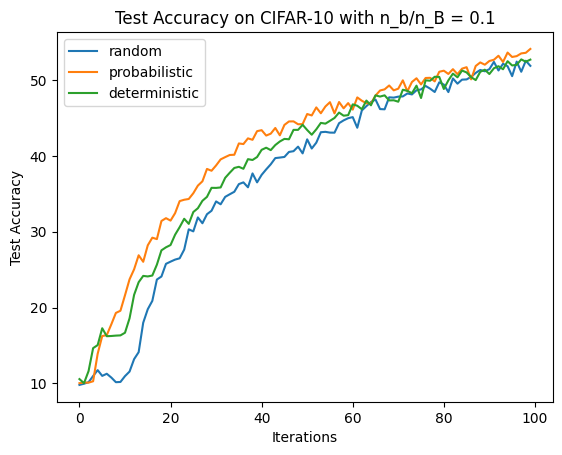

In [ ]:
# Plot test accuracies
for model_name, accuracies in test_accuracies.items():
  if model_name == 'standard':
    continue
  x_epochs = np.arange(0, epochs)
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

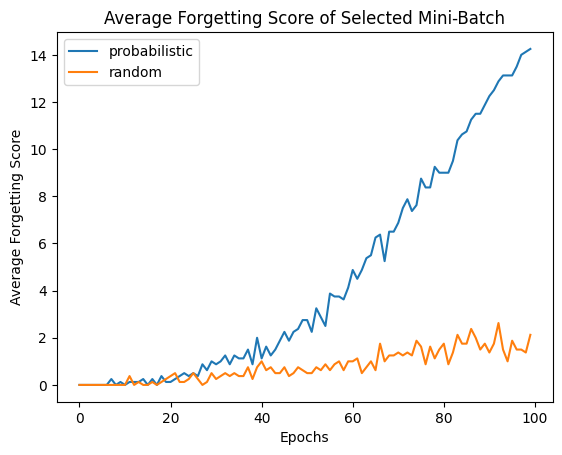

In [ ]:
plt.plot(forgetting_probabilistic, label='probabilistic')
plt.plot(forgetting_random, label='random')
plt.xlabel('Epochs')
plt.ylabel('Average Forgetting Score')
plt.title('Average Forgetting Score of Selected Mini-Batch')
plt.legend()
plt.show()

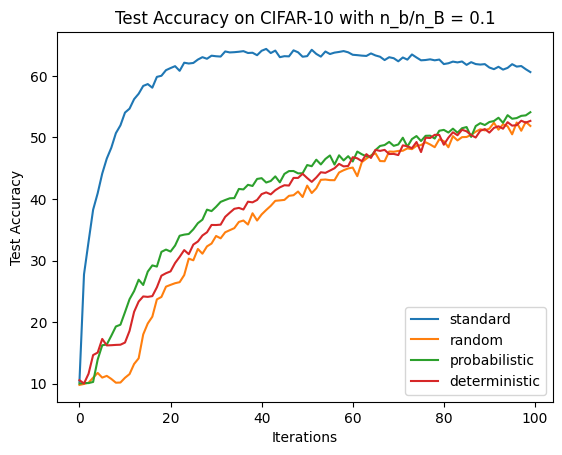

In [ ]:
# Plot test accuracies
for model_name, accuracies in test_accuracies.items():

  x_epochs = np.arange(0, epochs)
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

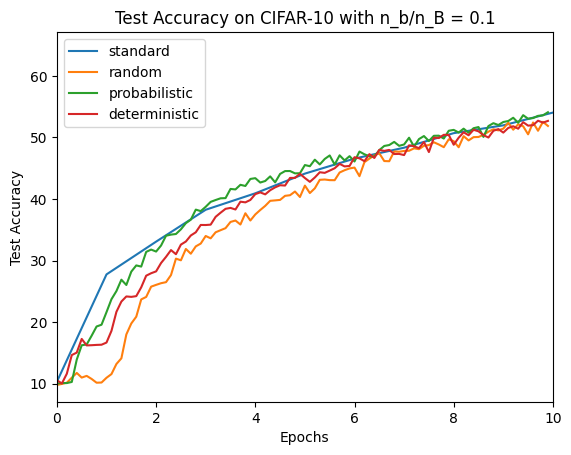

In [ ]:
# Plot test accuracies for balanced epochs
for model_name, accuracies in test_accuracies.items():
  if model_name == 'standard':
    x_epochs = np.arange(0, epochs)

  else:
    x_epochs = np.arange(0, epochs) * B_b
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlim(0, 10)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()
